In [1]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

# import itertool
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from matplotlib.patches import Circle, Rectangle

import math

# %matplotlib agg

In [2]:
import torch
import torch.nn as nn
import numpy as np

class StateModel(nn.Module):
    def __init__(self):
        super(StateModel, self).__init__()

        self.inputs = 3
        hidden = 5

        self.model = nn.Sequential(
            nn.Linear(self.inputs, hidden).double(),
            nn.ReLU(),
            nn.Linear(hidden, hidden).double(),
            nn.ReLU(),
            nn.Linear(hidden, hidden).double(),
            nn.ReLU(),
            nn.Linear(hidden, 2).double(),
        )    

    def __call__(self, s, a):
        # assert s.shape == a.shape
        # assert (s.shape[1] + a.shape[1]) == self.inputs
        
        # x = torch.from_numpy(np.concatenate((s, a)).reshape(s.shape[0], self.inputs)).type(torch.DoubleTensor) #factored actions
        x = torch.from_numpy(np.concatenate((s, a.reshape(a.shape[0], 1)), axis=1)).type(torch.DoubleTensor)
        return self.model(x)
    

model = StateModel()
s =  np.array([[0., 0.], [1., 0.], [1., -1.]])
# a =  np.array([[1., 0.], [0., -1.], [1., 0.]])
a =  np.array([0, 3, 1])


model(s,a)

tensor([[0.2730, 0.3661],
        [0.3321, 0.4396],
        [0.2536, 0.3428]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [3]:
import pandas as pd

def train(model, data, epochs=100, lr=0.01, momentum=.9):
    s,a,s_ = np.double(np.vstack(data.s)), np.double(data['a'].to_numpy()), np.double(np.vstack(data.s_))
    
    loss = nn.MSELoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    model.train(True)
    for _ in range(epochs):
        outputs = model(s, a)

        err = loss(outputs, torch.tensor(s_))
        
        optim.zero_grad()
        err.backward()
        optim.step() 
        
    model.train(False)


d = pd.DataFrame({'s': [[0., 0.], [1., 0.], [1., -1.]], 'a': [0, 3, 1], 's_': [[1., 0.], [1., -1.], [0., -1.]]})
m = StateModel()
train(m, d)

   step                                      s    a    r  \
0   1.0  [8.857891881392495, -9.3112133197924]  3.0  1.0   
0   2.0                  [8.773739, -8.680204]  0.0  1.0   
0   3.0                  [7.623954, -8.534207]  0.0  1.0   
0   4.0                 [6.9673734, -8.364347]  1.0  1.0   
0   5.0                 [7.8915825, -8.228003]  0.0  1.0   

                       s_  end  
0   [8.773739, -8.680204]  0.0  
0   [7.623954, -8.534207]  0.0  
0  [6.9673734, -8.364347]  0.0  
0  [7.8915825, -8.228003]  0.0  
0  [6.9534163, -8.601376]  0.0  


<AxesSubplot: >

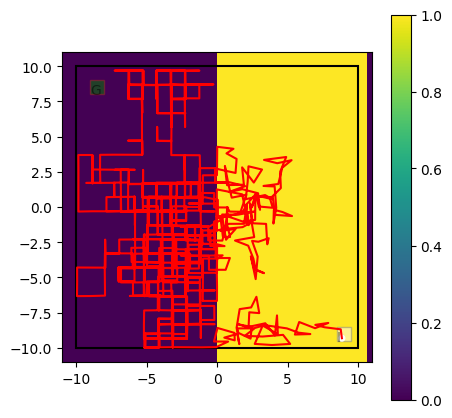

In [18]:
from src.environment import NormalMoveEnv
from src.rl import Trajectory

params = {
    'walls': [],
    'goals': [([-9.,8.],[-8.,9.])],
    'start': ([8.5,-9.5],[9.5,-8.5]),
    'beta': lambda s: (s[0]>0. and s[0]<10.)
}

env = NormalMoveEnv(**params)
t = Trajectory(env, size=1_000)
print(t.run.head())
ax = t.plot(env.plot())
ax

In [5]:
model = StateModel()
train(model, t.run, epochs=1000)

model(np.double(np.vstack(t.run.s)), np.double(t.run['a'].to_numpy()))

tensor([[ 8.2651, -8.9668],
        [ 8.6759, -8.9365],
        [ 8.8072, -9.3952],
        ...,
        [-9.2736,  7.7928],
        [-9.2694,  8.3650],
        [-9.1483,  8.2551]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [6]:
t.run.s_

0    [8.7322645, -8.889316]
0     [8.568588, -9.564307]
0     [8.809914, -8.402589]
0     [8.809914, -8.402589]
0     [9.008611, -9.492081]
              ...          
0     [-9.207666, 8.131365]
0    [-9.451049, 7.2282286]
0      [-9.60557, 7.839304]
0     [-9.721389, 8.370161]
0     [-8.212826, 8.294924]
Name: s_, Length: 685, dtype: object

In [16]:
np.mean(model(np.double(np.vstack(t.run.s)), np.double(t.run['a'].to_numpy())).detach().numpy() - np.vstack(t.run.s_), axis=0)

array([ 0.05377846, -0.04855787])